<a href="https://colab.research.google.com/github/HassanCoulibaly/MachineLearningProject/blob/side/Multiple_CNNs_%2B_bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Concatenate, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [11]:
train_df = pd.read_csv('dataset/train_df.csv')
test_df = pd.read_csv('dataset/test_df.csv')

In [12]:
vocab_size = 10000
max_length = 40
embedding_dim = 50

label_encoder = LabelEncoder()
label_encoder.fit(['negative', 'neutral', 'positive'])
y_train = tf.keras.utils.to_categorical(label_encoder.transform(train_df['sentiment']), num_classes=3)
y_test = tf.keras.utils.to_categorical(label_encoder.transform(test_df['sentiment']), num_classes=3)

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['tweet'])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['tweet']), maxlen=max_length, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['tweet']), maxlen=max_length, padding='post')

In [13]:
glove_path = 'dataset/glove.6B.50d.txt'
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [14]:
# 4. Build Model 8: Multi-CNN + Bidirectional LSTM
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], trainable=False)(input_layer)

cnn_3 = Conv1D(64, kernel_size=3, activation='relu')(embedding_layer)
cnn_4 = Conv1D(64, kernel_size=4, activation='relu')(embedding_layer)
cnn_5 = Conv1D(64, kernel_size=5, activation='relu')(embedding_layer)

pool_3 = GlobalMaxPooling1D()(cnn_3)
pool_4 = GlobalMaxPooling1D()(cnn_4)
pool_5 = GlobalMaxPooling1D()(cnn_5)

merged = Concatenate()([pool_3, pool_4, pool_5])



In [15]:
output = Dense(3, activation='softmax')(merged)

model8 = Model(inputs=input_layer, outputs=output)
model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model8.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 40, 50)    │    500,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 38, 64)    │      9,664 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 37, 64)    │     12,864 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 36, 64)    │     16,064 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_6[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_7[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_8[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 192)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │        579 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 539,171 (2.06 MB)

 Trainable params: 39,171 (153.01 KB)

 Non-trainable params: 500,000 (1.91 MB)

In [16]:
# 5. Train Model
history8 = model8.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5463 - loss: 0.9128 - val_accuracy: 0.5895 - val_loss: 0.8652
Epoch 2/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.6440 - loss: 0.7748 - val_accuracy: 0.5826 - val_loss: 0.8980
Epoch 3/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.6814 - loss: 0.7122 - val_accuracy: 0.6044 - val_loss: 0.8551
Epoch 4/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.7056 - loss: 0.6657 - val_accuracy: 0.5858 - val_loss: 0.9172
Epoch 5/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.7280 - loss: 0.6254 - val_accuracy: 0.5710 - val_loss: 0.9828
Epoch 6/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7492 - loss: 0.5884 - val_accuracy: 0.5968 - val_loss: 0.9215
Epoch 7/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7704 - loss: 0.5493 - val_accuracy: 0.5753 - val_loss: 0.9827
Epoch 8/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7828 -

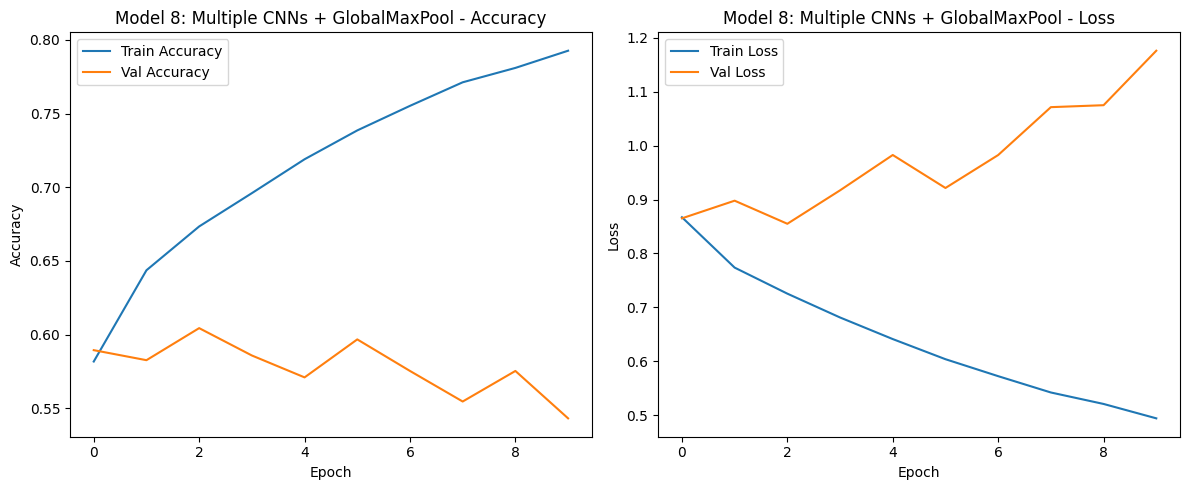

In [17]:
def plot_training_history(history, title='Model'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(history8, title='Model 8: Multiple CNNs + GlobalMaxPool')